In [40]:
import os
import matplotlib.pyplot as plt
import numpy as np
import k3d
import numpy as np
from skimage import io
from skimage.exposure import rescale_intensity
import cv2
from skimage.filters import gaussian

In [ ]:
!jupyter nbextension enable --py --user k3d

In [92]:
def pad_volume(size, volume):
    size_difference = size - volume.shape
    xr, yr, zr = ((size_difference)/2).astype(int)
    xl, yl, zl = size_difference - np.array([xr, yr, zr])
    return np.pad(volume, [[xl, xr], [yl, yr], [zl, zr]])

In [138]:
volumes = []
brains = ['MD585', 'MD589', 'MD594']
structure = 'IC'
for brain in brains:
    structure_path = f'/net/birdstore/Active_Atlas_Data/data_root/atlas_data/{brain}'
    volume_path = os.path.join(structure_path, 'structure', f'{structure}.npy')
    volume = np.load(volume_path)
    volumes.append(volume)
    print(volume.shape)


(102, 74, 173)
(87, 66, 177)
(82, 67, 162)


In [2]:
DATA = '/net/birdstore/Active_Atlas_Data/data_root/pipeline_data/MD589/preps/CH1/thumbnail_aligned.25um'
fpath = os.path.join(DATA, '111.tif')
img = cv2.imread(fpath, cv2.IMREAD_GRAYSCALE)

In [21]:
filepath = '/home/eddyod/.brainglobe/allen_mouse_10um_v1.2/annotation.tiff'
annotations = io.imread(filepath)

In [22]:
SC = annotations[annotations == 302]
SC.dtype

dtype('uint32')

In [23]:
ids, counts = np.unique(SC, return_counts=True)
print(ids)
print(counts)

[]
[]


In [14]:
def smooth_image(gray):
    # threshold
    thresh = cv2.threshold(gray, 32, 255, cv2.THRESH_BINARY)[1]
    # blur threshold image
    blur = cv2.GaussianBlur(thresh, (0,0), sigmaX=3, sigmaY=3, borderType = cv2.BORDER_DEFAULT)
    # stretch so that 255 -> 255 and 127.5 -> 0
    stretch = rescale_intensity(blur, in_range=(127.5,255), out_range=(0,255)).astype(np.uint8)
    # threshold again
    thresh2 = cv2.threshold(stretch, 0, 255, cv2.THRESH_BINARY)[1]
    # get external contour
    contours = cv2.findContours(thresh2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = contours[0] if len(contours) == 2 else contours[1]
    big_contour = max(contours, key=cv2.contourArea)
    # draw white filled contour on black background as mas
    contour = np.zeros_like(gray)
    cv2.drawContours(contour, [big_contour], 0, 255, -1)
    # dilate mask for dark border
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (12,12))
    dilate1 = cv2.morphologyEx(contour, cv2.MORPH_CLOSE, kernel)
    # apply morphology erode
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (8,8))
    dilate2 = cv2.morphologyEx(dilate1, cv2.MORPH_ERODE, kernel)
    # blur dilate image
    blur2 = cv2.GaussianBlur(dilate2, (3,3), sigmaX=0, sigmaY=0, borderType = cv2.BORDER_DEFAULT)
    # stretch so that 255 -> 255 and 127.5 -> 0
    mask = rescale_intensity(blur2, in_range=(127.5,255), out_range=(0,255))
    #return cv2.bitwise_and(gray, gray, mask=mask.astype(np.uint8))
    return cv2.bitwise_and(gray, mask.astype(np.uint8), mask=None)
    #return dilate1


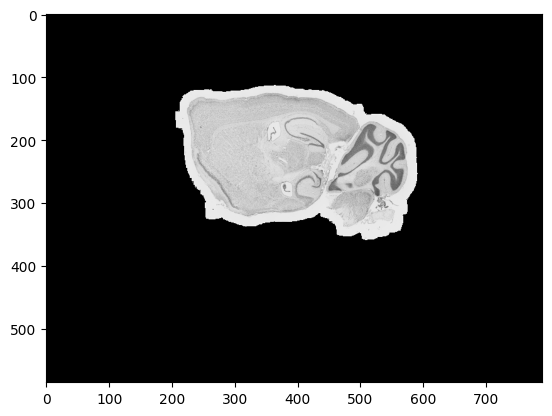

In [4]:
arr = img.copy()
arr[arr == 255] = 0
#arr[arr == 232] = 0
plt.imshow(arr, cmap='gray')

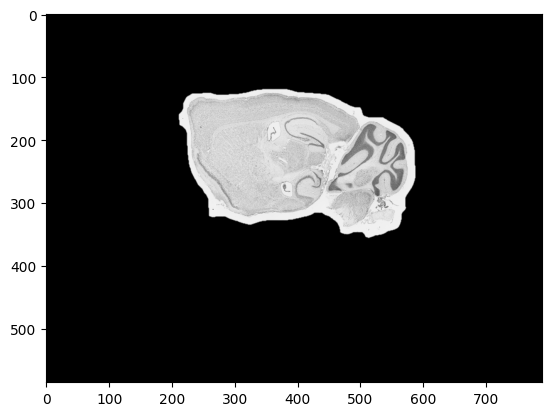

In [15]:
simg = img.copy()
simg[simg == 255] = 0
smooth_img = smooth_image(simg)
plt.imshow(smooth_img, cmap='gray')

In [136]:
def merge_volumes(volumes):
    sizes = np.array([vi.shape for vi in volumes])
    volume_size = sizes.max(0) + 100
    volumes = [pad_volume(volume_size, vi) for vi in volumes]
    volumes = list([(v > 0).astype(np.int32) for v in volumes])
    merged_volume = np.sum(volumes, axis=0)
    #merged_volume_prob = merged_volume / float(np.max(merged_volume))
    merged_volume_prob = merged_volume / float(len(volumes))
    # increasing the STD makes the volume smoother
    # Smooth the probability
    average_volume = gaussian(merged_volume_prob, 1.0)
    color = 1
    #average_volume = merged_volume_prob
    average_volume[average_volume > 0.3] = color
    average_volume[average_volume != color] = 0
    average_volume = average_volume.astype(np.uint8)
    return average_volume


In [139]:
merged_volume = merge_volumes(volumes)
plt_voxels = k3d.voxels(merged_volume.astype(np.uint8),  color_map=(0xfdfe03), outlines=False)
plot = k3d.plot(grid_visible=True, camera_auto_fit=True)
plot += plt_voxels
plot.display()

Output()